In [233]:
from utils import load_data, create_scores, generate_cal_opt_sets, create_random_split
from multi_dim_cp import allocate_points
from matplotlib import pyplot as plt
from matplotlib import colors
import numpy as np
from scipy.spatial import cKDTree
from matplotlib.patches import Patch
from utils import create_true_rest_sets
from tabulate import tabulate

np.random.seed(5)

In [234]:
config={
    'DATASET_NAME': 'PathMNIST_demo',
    
    'ALPHA': 0.02,
    
    'b': 1,
    
    'N_HEADS': [1,2,4,7],
    
    'SCORING_METHOD': 'RAPS'    
    
}

In [235]:
cal_output,cal_target,test_output,test_target=load_data(config)


In [236]:

def plot_set_size_per_head_comb(prediction_sets_d):
    for k,v in prediction_sets_d.items() :
        vec = v.sum(axis=1)
        bins = range(1, int(max(vec) + 2))
        plt.figure(figsize=(6, 4))
        plt.hist(vec, bins=bins, color='blue', alpha=0.5, align='left')
        plt.yscale('log')
        plt.xlabel("Set Size", fontsize=18)
        plt.ylabel('Log(Frequency)', fontsize=18)
        plt.title(f"Set Size Distribution For {k} Heads", fontsize=20)
        plt.grid(True)
        xticks_spacing = max(1, v.shape[1] // 10)
        plt.xticks(bins[::xticks_spacing], fontsize=14)
        plt.yticks(fontsize=14)
        plt.tight_layout(pad=2.0)
        plt.show()
        
        
def plot_selected_cells2(centers_unique, wanted_centers_idx,tests,num_dp=300,grid_resolution=5000):
    print(test[0].shape,test[1].shape)
    axis_max = max(np.max(centers_unique, axis=1)[0], np.max(centers_unique, axis=1)[1])
    x_min, x_max = 0, axis_max
    y_min, y_max = 0, axis_max
    x = np.linspace(x_min, x_max, grid_resolution)
    y = np.linspace(y_min, y_max, grid_resolution)
    xx, yy = np.meshgrid(x, y)
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    tree = cKDTree(centers_unique.T)
    closest_idx = tree.query(grid_points,k=config['b'])[1]
    scores_in = np.isin(closest_idx, wanted_centers_idx)
    scores_in = np.expand_dims(scores_in, axis=1) if scores_in.ndim == 1 else scores_in
    is_closest_wanted_grid = (scores_in.sum(axis=1) >= max(config['b'] * 0.5, 1)).reshape(grid_resolution, grid_resolution)
    cmap = colors.ListedColormap(['red', 'blue'])
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(is_closest_wanted_grid, extent=(x_min, x_max, y_min, y_max), origin='lower', cmap=cmap, zorder=-1, alpha=0.5)
    ax.scatter(tests[0][0, :num_dp], tests[0][1, :num_dp], color='k', edgecolors='white', alpha=0.4, zorder=1,
               label='True test points')
    ax.scatter(tests[1][0, :num_dp].reshape(-1), tests[1][1, :num_dp].reshape(-1), color='purple', marker='x', alpha=0.1,
               label='Rest test points')
    ax.set_xlabel(r'$s_1(x,y)$', fontsize=16)
    ax.set_ylabel(r'$s_2(x,y)$', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=16)
    legend_patches = [
        Patch(color='blue', label='Selected regions'),
        Patch(color='red', label='Unselected regions')
    ]
    handles, labels = ax.get_legend_handles_labels()
    handles.extend(legend_patches)
    ax.legend(handles=handles, loc='lower right', fontsize=18)
    plt.xlim(0, axis_max)
    plt.ylim(0, axis_max)
    plt.show()

In [237]:
prediction_sets_d={}
results_table = []

for n_head in config['N_HEADS']:
    cal_output_new, cal_target_new, test_output_new, test_target_new = create_random_split(cal_output[:n_head, :, :], cal_target, test_output[:n_head, :, :], test_target)
    cal_scores =create_scores(cal_output_new,config)
    test_scores =create_scores(test_output_new,config)
    precal_scores,precal_target,opt_scores,opt_target=generate_cal_opt_sets(cal_scores, cal_target_new)
    coverage, mean_set,prediction_sets_new_meth,(wanted_centers,cal_true_preds_with_zero) = allocate_points(precal_scores, precal_target,opt_scores, opt_target, test_scores,test_target_new, config['ALPHA'],config)
    prediction_sets_d[n_head]=prediction_sets_new_meth
    if n_head==2:
        test=create_true_rest_sets(test_scores,test_target_new,'CAL')
        args_for_selected_cells_plot=[cal_true_preds_with_zero,wanted_centers,test]
    results_table.append([n_head,coverage,1 - config['ALPHA'],round(mean_set, 3)])

headers = ["N_HEAD", "Coverage archived", "Coverage wanted", "Mean-Predicted-Set-Size"]
print(tabulate(results_table, headers=headers, tablefmt="pretty"))



+--------+--------------------+-----------------+-------------------------+
| N_HEAD | Coverage archived  | Coverage wanted | Mean-Predicted-Set-Size |
+--------+--------------------+-----------------+-------------------------+
|   1    | 0.9817130061578653 |      0.98       |          4.465          |
|   2    | 0.9823661130807987 |      0.98       |          2.305          |
|   4    | 0.9816197051688748 |      0.98       |          1.718          |
|   7    | 0.9793804814331032 |      0.98       |          1.162          |
+--------+--------------------+-----------------+-------------------------+


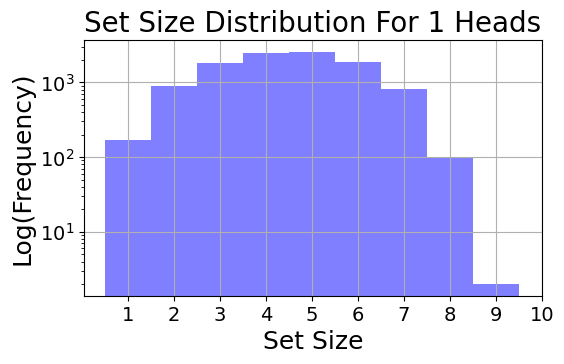

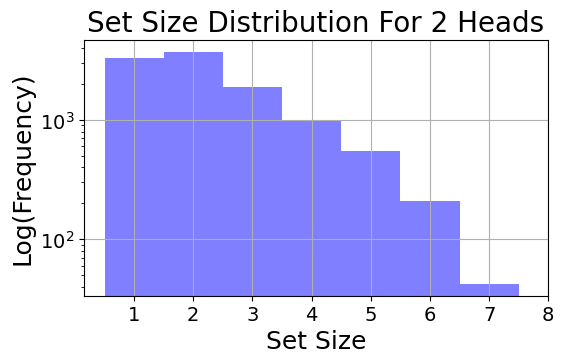

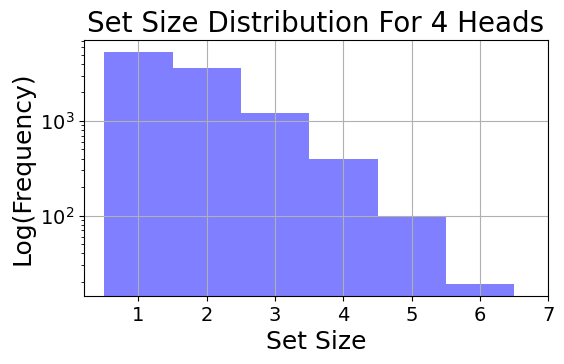

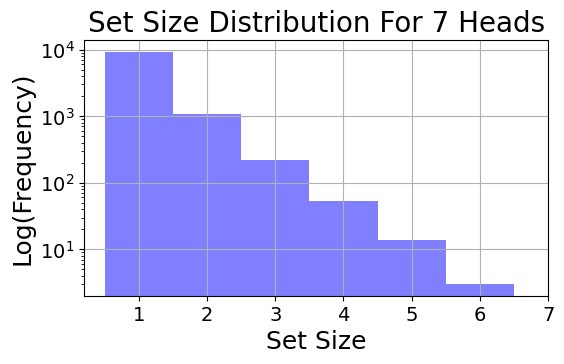

In [238]:
plot_set_size_per_head_comb(prediction_sets_d)


(2, 10718) (2, 10718, 9)


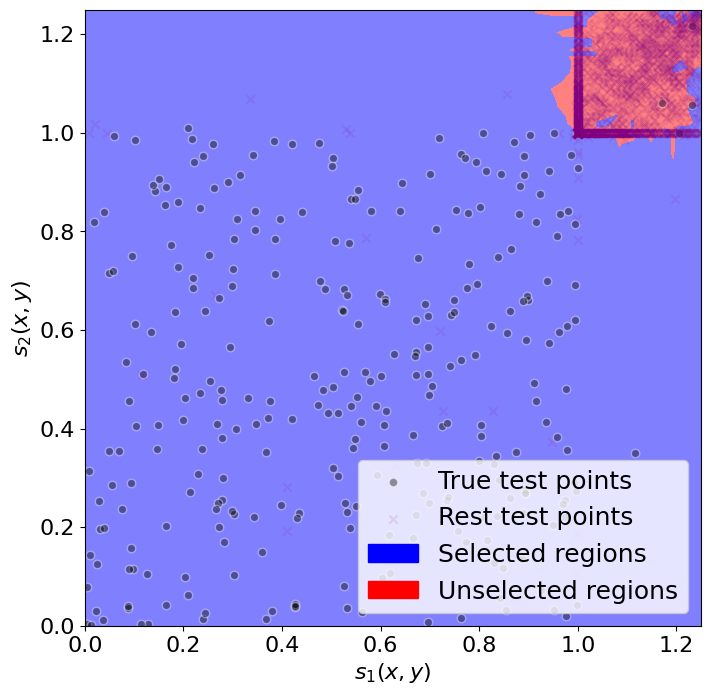

In [239]:
if 2 in config['N_HEADS']:
    plot_selected_cells2(*args_for_selected_cells_plot)